In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft
from scipy.signal import periodogram
import ordpy 
import statsmodels.api as sm
from scipy.signal import butter,filtfilt
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.stattools import adfuller

In [83]:
#list all the data files and its path
files = []
onlyfiles = [f for f in listdir('../Data') if isfile(join('../Data', f))]
for i in range(len(onlyfiles)):
    path = '../Data/' + onlyfiles[i]
    files.append(path)
files

['../Data/330751_painpred_2023-02-11_17h13.42.930.csv',
 '../Data/498359_painpred_2023-02-11_23h17.45.418.csv',
 '../Data/512857_painpred_2023-02-12_11h48.23.891.csv',
 '../Data/593908_painpred_2023-02-12_05h52.13.082.csv',
 '../Data/856201_painpred_2023-02-11_15h47.33.934.csv',
 '../Data/887302_painpred_2023-02-11_18h25.46.860.csv',
 '../Data/9_250095_painpred_2023-02-12_15h29.43.618.csv',
 '../Data/9_387308_painpred_2023-02-12_18h45.27.469.csv',
 '../Data/9_710022_painpred_2023-02-12_19h12.57.588.csv',
 '../Data/9_793523_painpred_2023-02-12_19h57.29.361.csv',
 '../Data/9_815709_painpred_2023-02-12_13h34.23.222.csv',
 '../Data/9_965235_painpred_2023-02-12_23h11.59.775.csv']

# Preprocessing Functions
For windowing, I realise the reaction time is always the longest in the first trial. So I think we could window more (start from 6 seconds) for the first trial?

In [84]:

def window_value(rating, time): #use values instead of timing to window
    rating_windowed_list = []
    time_windowed_list = []
    failed_index_list = [] #capture error in data logging
    #window the trials by finding the first time that they have changed their rating
    for i in range(len(rating)):
        if len(rating) > 1: #catch the whole entry being NaN
            #catch nan, catch hitting middle of confidence slider, catch ending time
            #i.e. this condidtion is it taps on the middle of the confidence slider
            if len(rating[i]) > 1 and time[i][0] < 0.1 and time[i][-1] > 10:
                res_unchanged = next(x for x, val in enumerate(rating[i]) if val != rating[i][0])
                rating_windowed = rating[i][res_unchanged:len(rating[i])]
                time_windowed = time[i][res_unchanged:len(rating[i])]
                #replace trials with error in data logging with nan
                #for trials that has a very long reaction time (about 10 seconds), filter it away
                if time_windowed[0] < 10 and len(time_windowed) > 100:
                    rating_windowed_list.append(rating_windowed)
                    time_windowed_list.append(time_windowed)
                else:
                    rating_windowed_list.append([np.NaN])
                    time_windowed_list.append([np.NaN])
                    failed_index_list.append(i)
            #condition: no nan but tap on the slider (0.1s being the reaction time)
            elif len(rating[i]) > 1 and time[i][0] > 0.1 and time[i][-1] > 10:
                rating_windowed = rating[i] #don't window as it starts recording only when click the slider
                time_windowed = time[i]
                if time_windowed[0] < 10 and len(time_windowed) > 100:
                    rating_windowed_list.append(rating_windowed)
                    time_windowed_list.append(time_windowed)
                else:
                    rating_windowed_list.append([np.NaN])
                    time_windowed_list.append([np.NaN])
                    failed_index_list.append(i)
            else:
                rating_windowed_list.append([np.NaN])
                time_windowed_list.append([np.NaN])
                failed_index_list.append(i)
        else:
            rating_windowed_list.append([np.NaN])
            time_windowed_list.append([np.NaN])


    
        
    return rating_windowed_list, time_windowed_list, failed_index_list

    

def lowpass_butter(rating, time, cutoff, order=5):
    lowpass_list = [] #list for all 30 trials
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            N = len(rating[i])
            T = time[i][-1]-time[i][0]
            fs = N/T
            nyq = fs*0.5
            normal_cutoff = cutoff / nyq
            b, a = butter(order, normal_cutoff, btype='low', analog=False)
            y = filtfilt(b, a, rating[i])
            lowpass_list.append(y)
        else:
            lowpass_list.append([np.NaN])
    return lowpass_list
        


def exponential_smoothing_trial(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def exponential_smoothing(rating, alpha):
    lowpass_list = [] #list of all 30 trials
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            result = [rating[i][0]] # first value is same as series
            for n in range(1, len(rating[i])):
                result.append(alpha * rating[i][n] + (1 - alpha) * result[n-1])
            lowpass_list.append(result)
        else:
            lowpass_list.append([np.nan])
    return lowpass_list


        
    

# Analysis Functions

In [85]:
#mean, mean square, root mean square, variance, standard deviation
def mean(rating):
    mean_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            mean_list.append(np.mean(rating[i]))
        else:
            mean_list.append(np.NaN)
    return mean_list

def mean_square(rating, time): #strength/average power of the signal
    mean_square_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            mean_square_list.append(np.sum(np.array(rating[i]) ** 2)/(max(time[i]) - min(time[i])))
        else:
            mean_square_list.append(np.NaN)
    return mean_square_list

def rms(mean_square_list):
    return np.sqrt(mean_square_list)

def variance(rating,time):
    variance_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            diff_mean_square_sum = np.sum((rating[i] - np.mean(rating[i]))**2)
            variance = diff_mean_square_sum/(max(time[i]) - min(time[i]))
            variance_list.append(variance)
        else:
            variance_list.append(np.NaN)
    return variance_list

def std(variance_list):
    return np.sqrt(variance_list)
  


#frequency np.fft

def fft_data(rating, time):
    fft_weights_list = []
    fft_freq_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            fft_weights = fft(rating[i])
            N = len(fft_weights)
            n = np.arange(N)
            T = time[i][-1]-time[i][0]
            fft_freq = n/T
            fft_weights_list.append(fft_weights)
            fft_freq_list.append(fft_freq)
        else:
            fft_weights_list.append([np.NaN])
            fft_freq_list.append([np.NaN])
    return fft_weights_list, fft_freq_list


#power-spectrum
def power_spectrum(rating,time):
    psd_freq_list = []
    psd_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            N = len(rating[i])
            T = time[i][-1]
            f, S = periodogram(rating[i], N/T, scaling = 'density')
            psd_freq_list.append(f)
            psd_list.append(S)
        else:
            psd_freq_list.append([np.NaN])
            psd_list.append([np.NaN])
    return psd_freq_list, psd_list


#permutation entropy - complexity
def permutation_entropy(rating):
    entropy_list = []
    stat_complexity_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            entropy, stat_complexity = ordpy.complexity_entropy(rating[i])
            entropy_list.append(entropy)
            stat_complexity_list.append(stat_complexity)
        else:
            entropy_list.append(np.NaN)
            stat_complexity_list.append(np.NaN)
    return entropy_list, stat_complexity_list

#autocorrelation
def autocorrelation(rating):
    acorr_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            acorr = sm.tsa.acf(rating[i], nlags = int(len(rating[i])))
            acorr_list.append(acorr)
        else:
            acorr_list.append([np.NaN])
    return acorr_list

#check stationarity
def adfuller_test(rating):
    adfuller_list = []
    stationary_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            result = adfuller(rating[i])
            adfuller_list.append(result)
            if result[1] <= 0.05:
                stationary_list.append(1)
            else:
                stationary_list.append(0)
        else:
            adfuller_list.append(np.nan)
            stationary_list.append(np.nan)
    labels = ['ADF Test Statistic','p-value','#Lags Used','#Observation Used']
    return adfuller_list, labels, stationary_list
    


# Remove data that failed the quiz

In [86]:
failed_files_index = []
for file in range(len(files)):
    data = pd.read_csv(files[file])
    if 'trials_fail.ran' in data.columns:
        failed_files_index.append(file)
for i in sorted(failed_files_index):
    del files[i]
files

['../Data/330751_painpred_2023-02-11_17h13.42.930.csv',
 '../Data/498359_painpred_2023-02-11_23h17.45.418.csv',
 '../Data/512857_painpred_2023-02-12_11h48.23.891.csv',
 '../Data/593908_painpred_2023-02-12_05h52.13.082.csv',
 '../Data/856201_painpred_2023-02-11_15h47.33.934.csv',
 '../Data/887302_painpred_2023-02-11_18h25.46.860.csv',
 '../Data/9_250095_painpred_2023-02-12_15h29.43.618.csv',
 '../Data/9_387308_painpred_2023-02-12_18h45.27.469.csv',
 '../Data/9_710022_painpred_2023-02-12_19h12.57.588.csv',
 '../Data/9_793523_painpred_2023-02-12_19h57.29.361.csv',
 '../Data/9_815709_painpred_2023-02-12_13h34.23.222.csv',
 '../Data/9_965235_painpred_2023-02-12_23h11.59.775.csv']

# Plotting the prediction and confidence data
## Filter participants
Replace data with NaN if reaction time > 10 seconds. If more than 20% of the data is > 10 seconds, remove participant

C:\Users\sharonho\AppData\Local\Temp\ipykernel_5624\3630569628.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


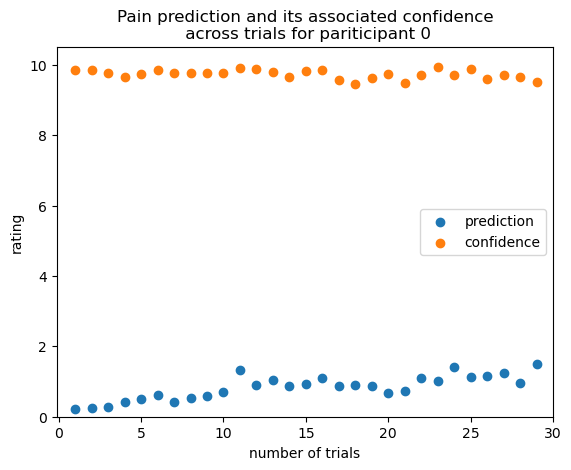

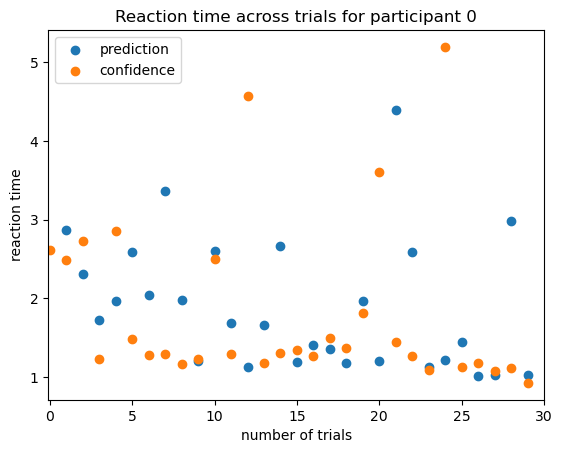

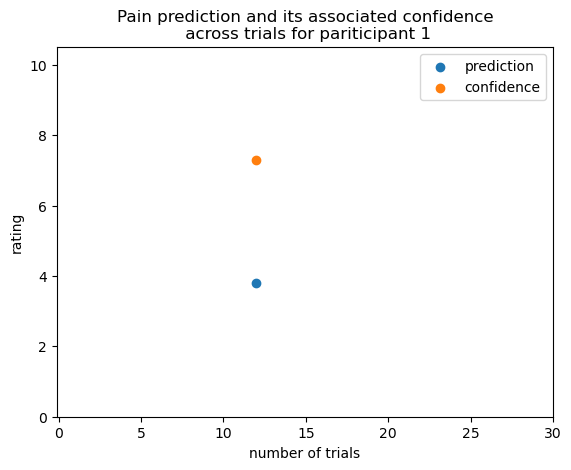

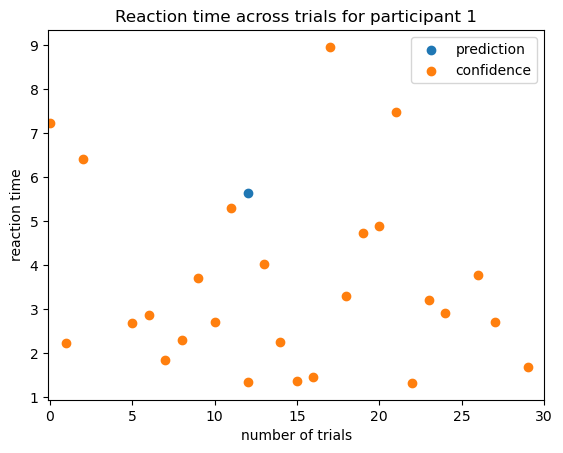

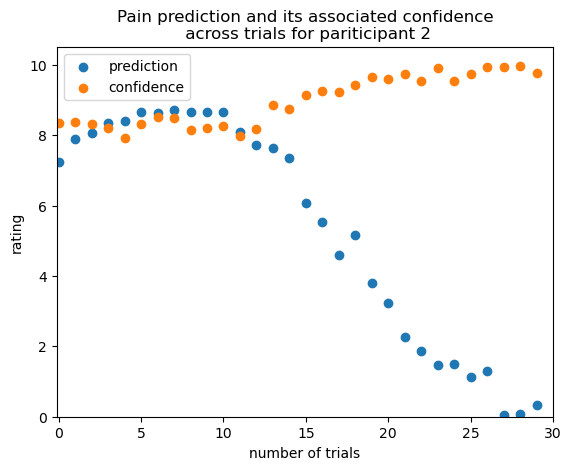

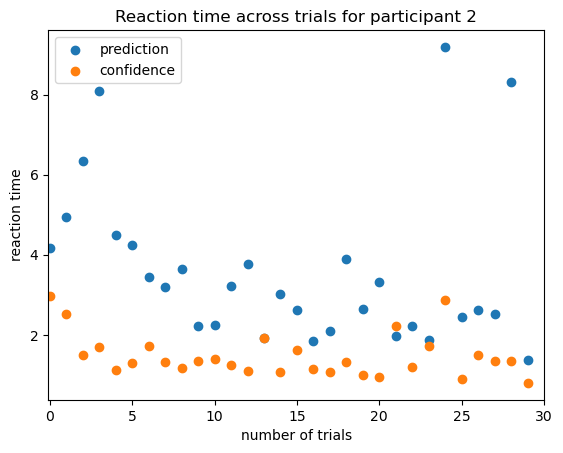

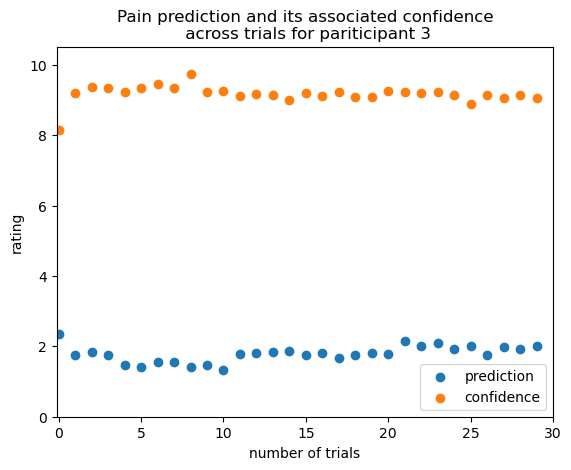

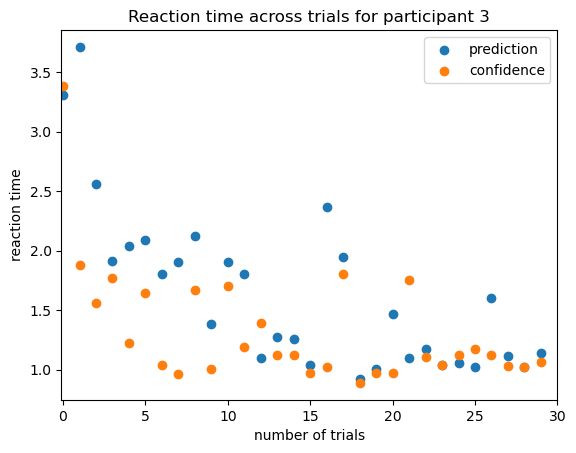

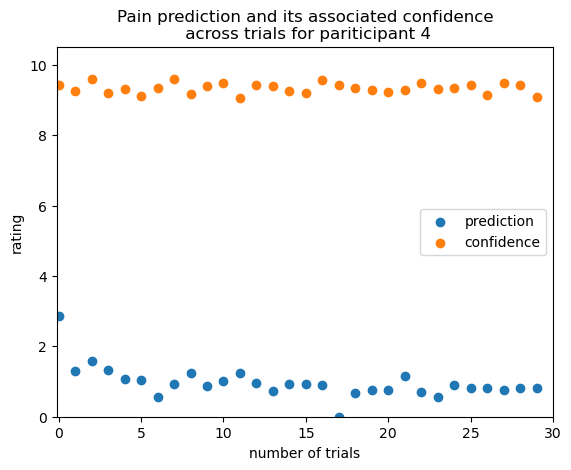

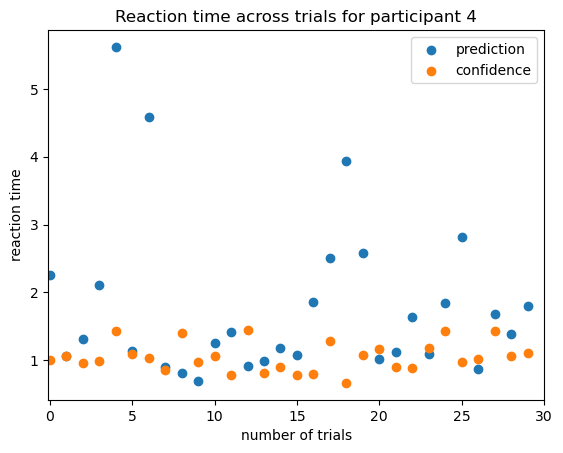

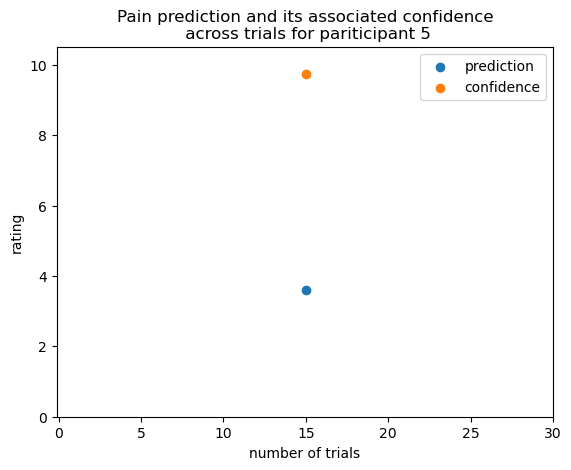

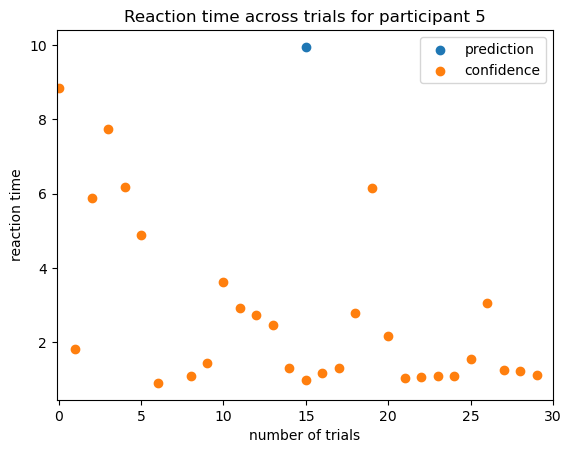

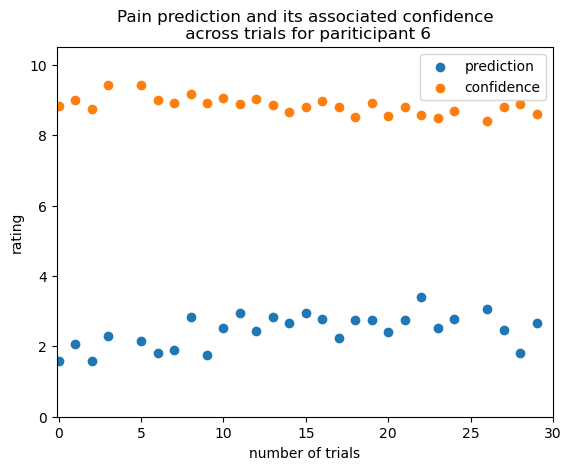

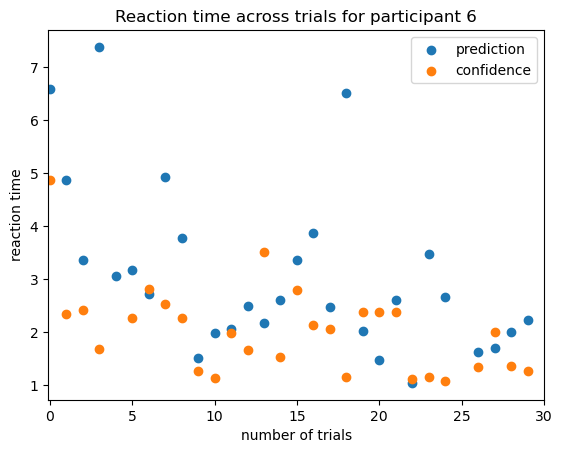

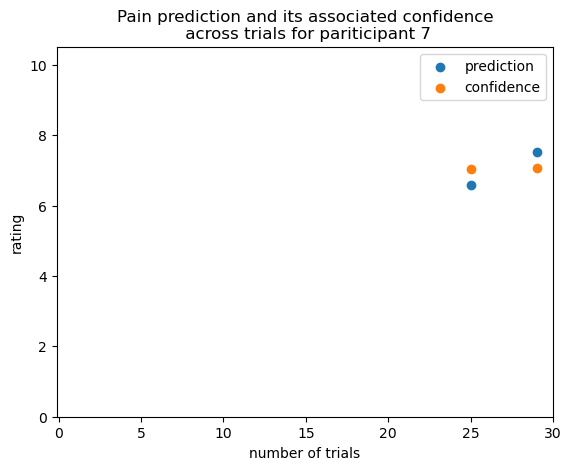

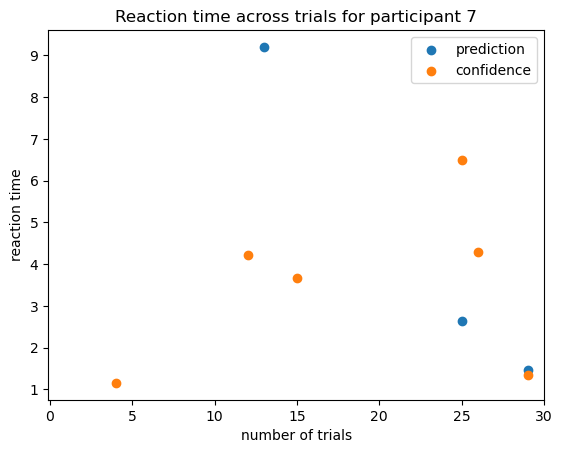

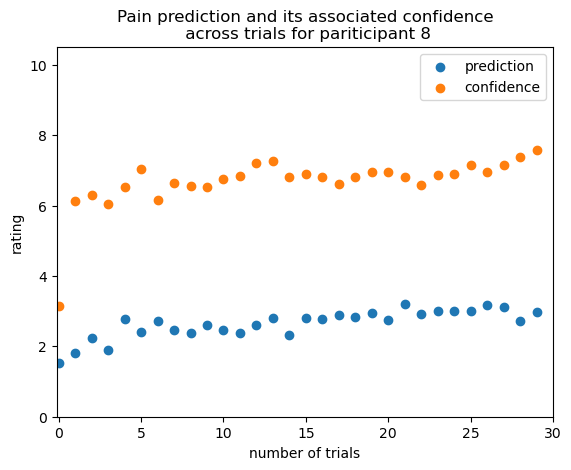

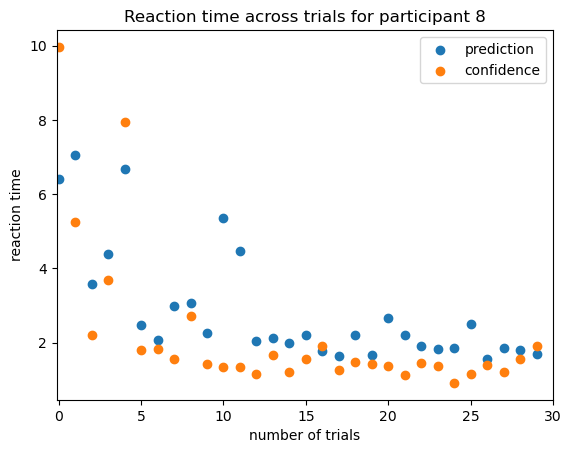

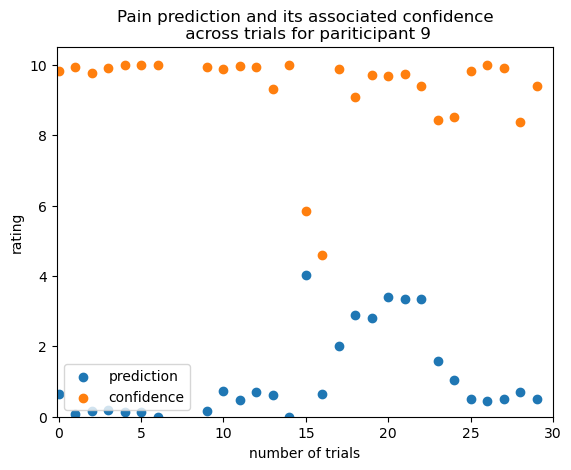

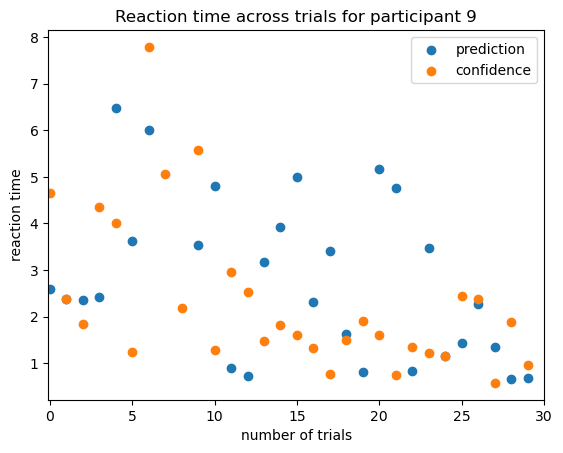

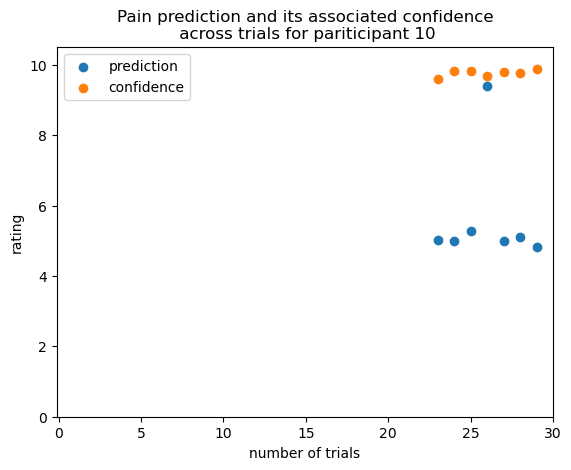

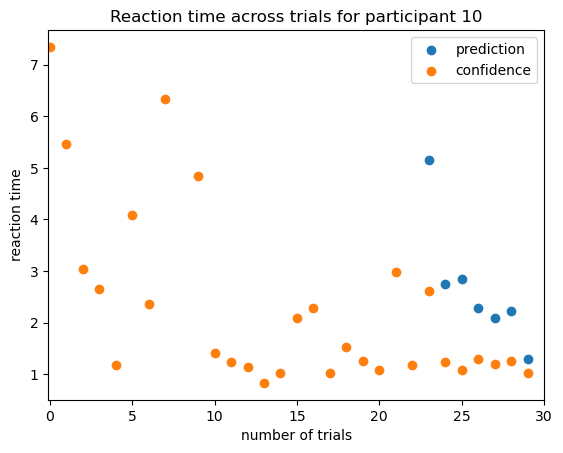

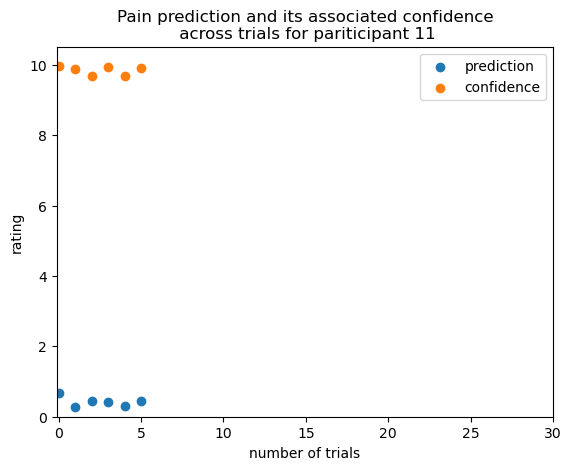

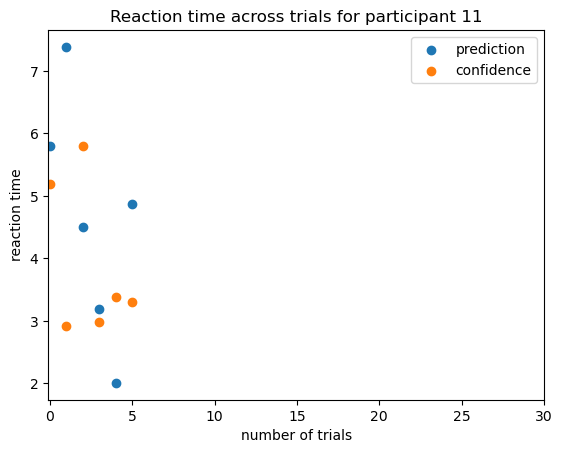

In [87]:
predict_data_all = []
confidence_data_all = []
predict_rt_all = []
confidence_rt_all = []

retained_index = []

loops = 30
for file in range(len(files)):
    data = pd.read_csv(files[file])
    predict_data = data['pain_predict_slider.response'][len(data)-1-loops:len(data)-1].reset_index().drop(columns = 'index')
    confidence_data = data['confidence_slider_2.response'][len(data)-1-loops:len(data)-1].reset_index().drop(columns = 'index')
    predict_rt = data['pain_predict_slider.rt'][len(data)-1-loops:len(data)-1].reset_index().drop(columns = 'index')
    confidence_rt = data['confidence_slider_2.rt'][len(data)-1-loops:len(data)-1].reset_index().drop(columns = 'index')

    #filtering with reaction time
    #replace with nan if reaction time > 10

    rej_index_pred = []
    rej_index_conf = []
    total_reject = []
    predict_rt_bool = pd.isnull(predict_rt).any(1)
    index_pred = predict_rt_bool[predict_rt_bool].index
    rej_index_pred.append(index_pred)
    confidence_rt_bool = pd.isnull(confidence_rt).any(1)
    index_conf = confidence_rt_bool[confidence_rt_bool].index
    rej_index_conf.append(index_conf)
    confidence_data.iloc[index_pred] = np.NaN
    confidence_data.iloc[index_conf] = np.NaN
    predict_data.iloc[index_pred] = np.NaN
    predict_data.iloc[index_conf] = np.NaN

    #if rejected trials > 10% of overall trials, remove the participant
    #count number of reject
    threshold = len(predict_data)*0.2
    for i in range(len(index_pred)):
        total_reject.append(index_pred[i])
    for i in range(len(index_conf)):
        total_reject.append(index_conf[i])
    total_reject_unique = list(dict.fromkeys(total_reject))
    
    if len(total_reject_unique) < threshold:
        retained_index.append(file)
        #append onto array with all data
        predict_data_all.append(predict_data*10)
        confidence_data_all.append(confidence_data*10)
        predict_rt_all.append(predict_rt)
        confidence_rt_all.append(confidence_rt)
    else:
        predict_data_all.append(np.nan)
        confidence_data_all.append(np.nan)
        predict_rt_all.append(np.nan)
        confidence_rt_all.append(np.nan)



    #plot
    plt.figure()
    plt.scatter(range(len(predict_data)), predict_data*10, label = 'prediction')
    plt.scatter(range(len(confidence_data)), confidence_data*10, label = 'confidence')
    plt.xlabel('number of trials')
    plt.ylabel('rating')
    plt.ylim(0,10.5)
    plt.xlim(-0.1,len(predict_data))
    plt.title(f'Pain prediction and its associated confidence\n across trials for pariticipant {file}')
    plt.legend()
    plt.figure()
    plt.scatter(range(len(predict_rt)), predict_rt, label = 'prediction')
    plt.scatter(range(len(confidence_rt)), confidence_rt, label = 'confidence')
    plt.xlabel('number of trials')
    plt.ylabel('reaction time')
    plt.xlim(-0.1,len(predict_data))
    plt.title(f'Reaction time across trials for participant {file}')
    plt.legend()

In [88]:
retained_index

[0, 2, 3, 4, 6, 8, 9]

# Put continuous pain data into correct form & visualise

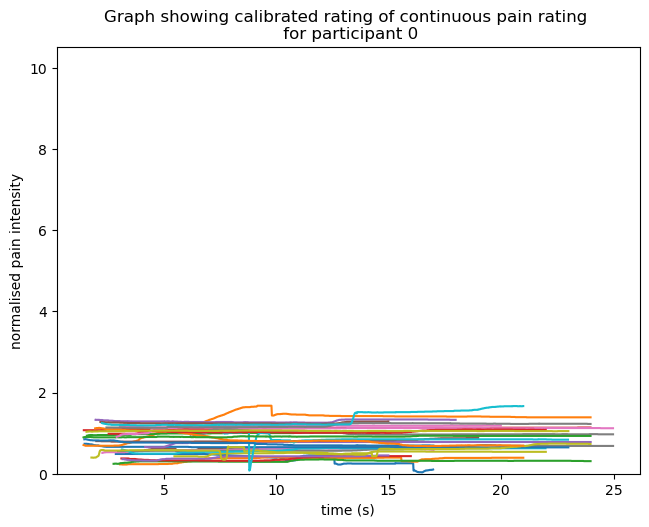

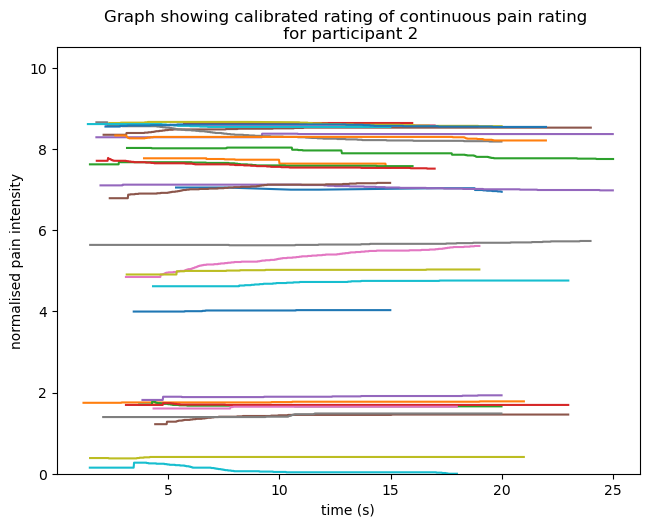

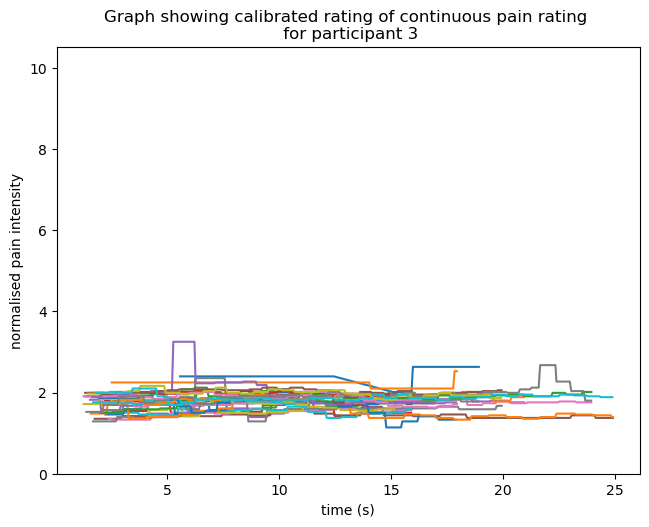

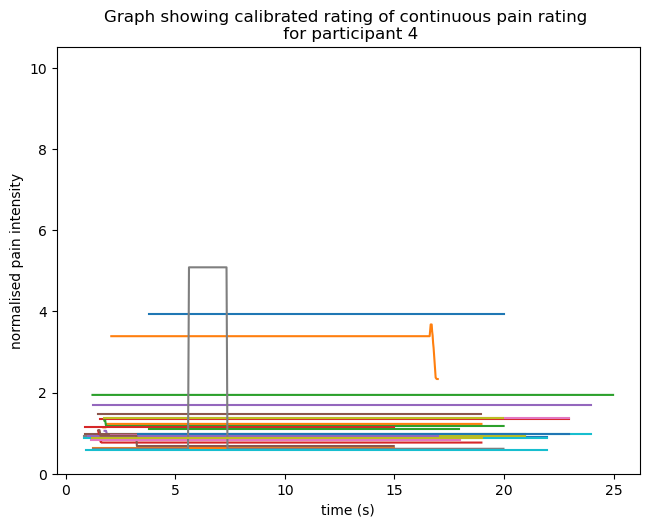

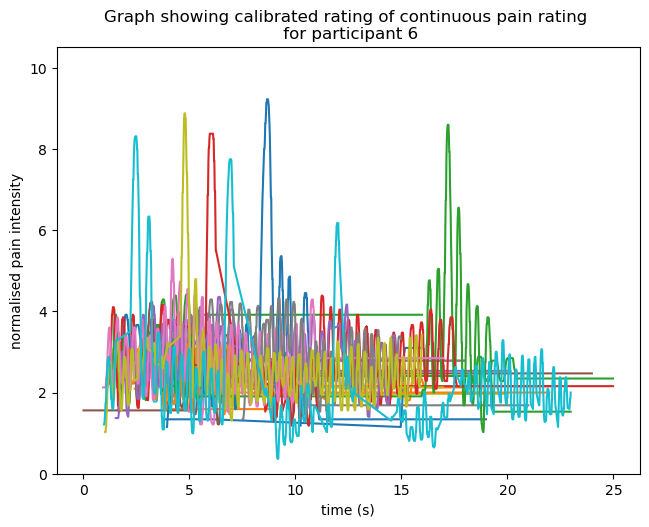

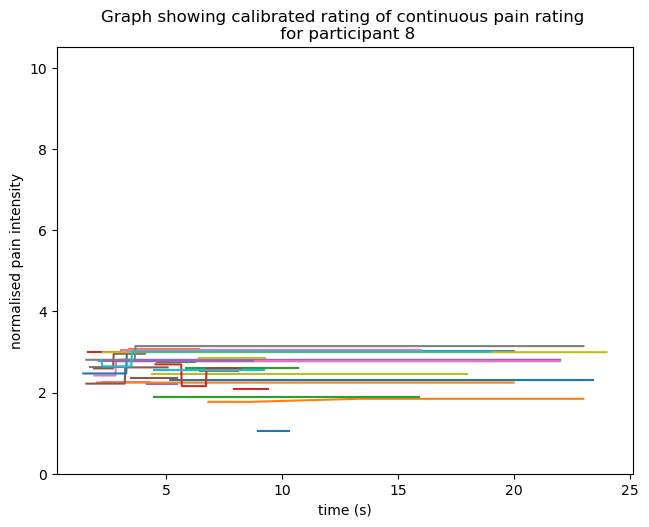

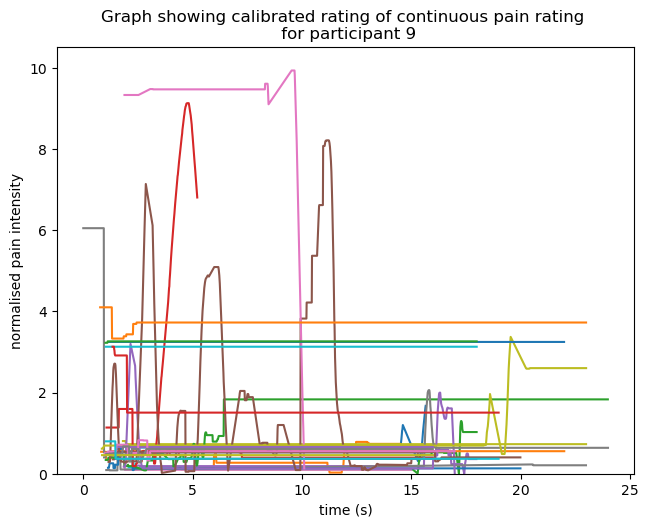

In [89]:
mouse_slider_rating_list_all = []
mouse_slider_time_list_all = []

for index in range(len(files)):
    if index in retained_index:
        plt.figure()
        data = pd.read_csv(files[index])

        #obtain relevant data

        #mouse_slider_data = data['mouse_slider.y'][len(data)-1-loops:len(data)-1]
        mouse_slider_data = []
        for j in range(len(data)-loops-1,len(data)-1,1):
            if type(data['mouse_slider.y'].iloc[j]) == str and len(data['mouse_slider.y'].iloc[j]) > 2:
                mouse_slider_data.append([float(data['mouse_slider.y'][j][1:-1].split(",")[i]) for i in range(len(data['mouse_slider.y'][j][1:-1].split(",")))])
            else:
                mouse_slider_data.append([np.nan])
        mouse_slider_time = data['mouse_slider.time']
        mouse_slider_time_data = []
        for j in range(len(data)-loops-1,len(data)-1,1):
            if type(data['mouse_slider.y'].iloc[j]) == str and len(data['mouse_slider.y'].iloc[j]) > 2:
                mouse_slider_time_data.append([float(data['mouse_slider.time'][j][1:-1].split(",")[i]) for i in range(len(data['mouse_slider.time'][j][1:-1].split(",")))])
            else:
                mouse_slider_time_data.append([np.nan])
        #calibration (normalise)
        mouse_slider_rating_list = []
        mouse_slider_time_list = []
        mouse_top_position = data['mouse_slider.top'][len(data)-2]
        mouse_bottom_position = data['mouse_slider.bottom'][len(data)-2]
        max_number = []
        min_number = []
        #note the beginning of the first train always starts from below the bottom of the slider due to the artefact from the position of the start button so when normalising we ignore the data of the artefact hence the data is a bit out of range
        for i in range(0,len(mouse_slider_data)):
            max_number.append(max(mouse_slider_data[i]))
            min_number.append(min(mouse_slider_data[i]))
        if max(max_number) > mouse_top_position:
            mouse_top_position = max(max_number)
        if min(min_number) < mouse_bottom_position:
            mouse_bottom_position = min(min_number)
        continuous_length = mouse_top_position - mouse_bottom_position

        for i in range(len(mouse_slider_data)):
            mouse_slider_data_np = np.array(mouse_slider_data[i])
            mouse_slider_time_np = np.array(mouse_slider_time_data[i])
            mouse_slider_time_list.append(mouse_slider_time_np)
            mouse_slider_rating = (mouse_slider_data_np - mouse_bottom_position)/continuous_length*10
            mouse_slider_rating_list.append(mouse_slider_rating)
        mouse_slider_rating_list_all.append(mouse_slider_rating_list)
        mouse_slider_time_list_all.append(mouse_slider_time_list)

        #plot
        for i in range(len(mouse_slider_data)):
            plt.plot(mouse_slider_time_list[i], mouse_slider_rating_list[i], label = i+1)
            plt.ylim(0,10.5)
        #plt.legend()
        plt.tight_layout()
        plt.title(f'Graph showing calibrated rating of continuous pain rating \n for participant {index}')
        plt.xlabel('time (s)')
        plt.ylabel('normalised pain intensity')
    else:
        mouse_slider_rating_list_all.append([np.nan])
        mouse_slider_time_list_all.append([np.nan])
    




# Pre-process the data

In [90]:
#with the timing method
rating_windowed_list_all = []
time_windowed_list_all = []
lowpass_list_all = []
retained_participants_list = []


#cutoff = 1
for j in range(len(mouse_slider_rating_list_all)):
    rating_windowed_list, time_windowed_list, failed_index = window_value(mouse_slider_rating_list_all[j], mouse_slider_time_list_all[j])
    rating_windowed_list_all.append(rating_windowed_list)
    time_windowed_list_all.append(time_windowed_list)
    lowpass_list = exponential_smoothing(rating_windowed_list, alpha = 0.1)
    lowpass_list_all.append(lowpass_list)
    if len(failed_index) < loops/3 and j in retained_index:
        retained_participants_list.append(j)
    

## Plot smoothed data

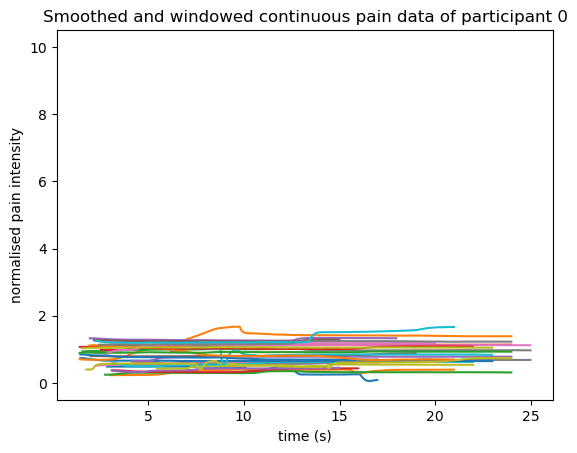

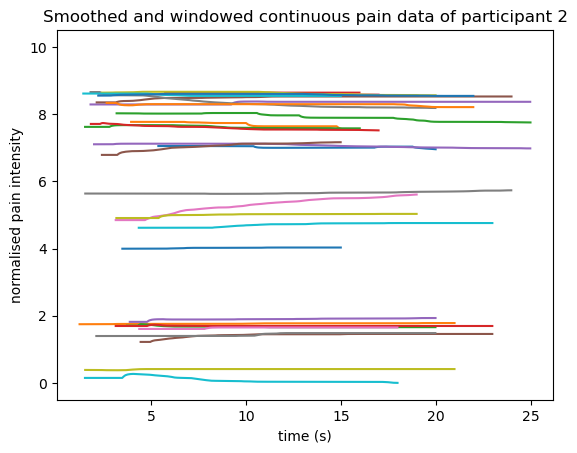

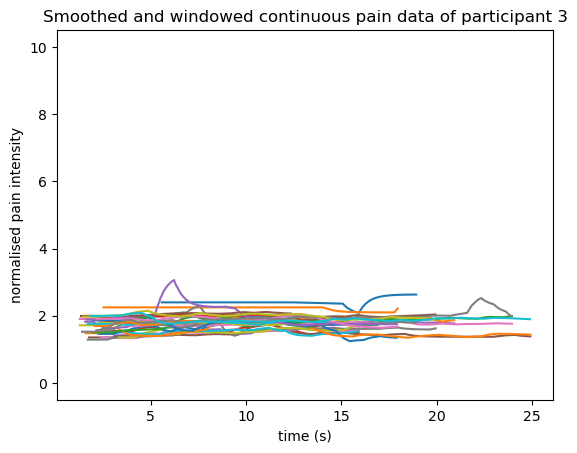

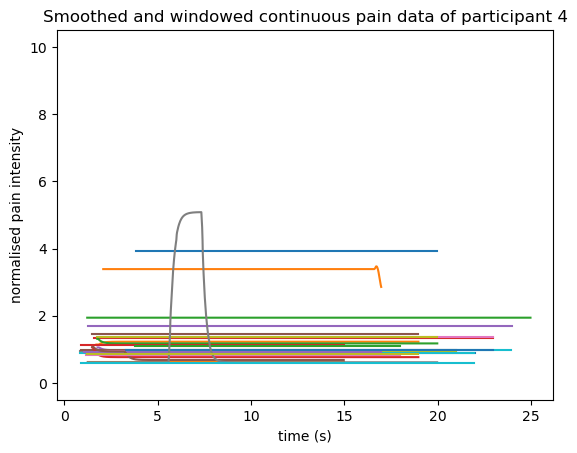

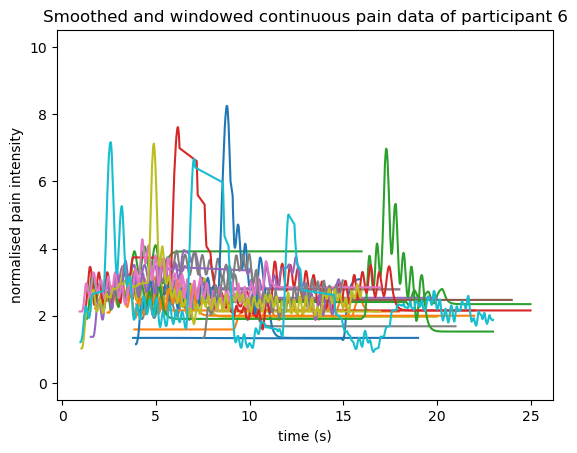

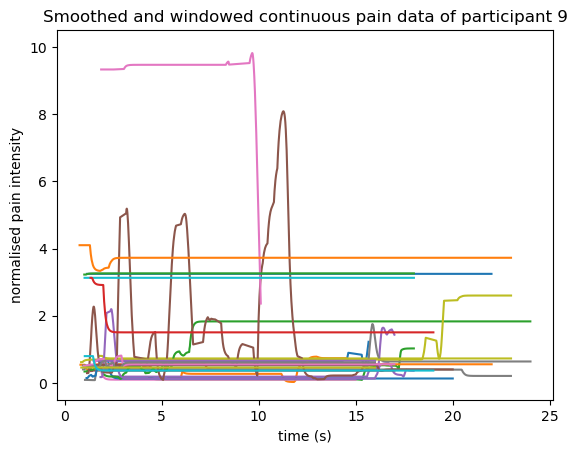

In [91]:
for i in range(len(time_windowed_list_all)):
    if i in retained_participants_list:
        plt.figure()
        for j in range(len(time_windowed_list_all[i])):
            plt.plot(time_windowed_list_all[i][j],lowpass_list_all[i][j])
            plt.ylabel('normalised pain intensity')
            plt.xlabel('time (s)')
            plt.ylim(-0.5,10.5)
            plt.title(f'Smoothed and windowed continuous pain data of participant {i}')

In [92]:
retained_participants_list

[0, 2, 3, 4, 6, 9]

# Analysis
## common statistical parameters

In [93]:
mean_list_all = []
mean_square_list_all = []
rms_list_all = []
variance_list_all = []
std_list_all = []
for j in range(len(lowpass_list_all)):
    if j in retained_participants_list:
        mean_list = mean(lowpass_list_all[j])
        mean_square_list = mean_square(lowpass_list_all[j], time_windowed_list_all[j])
        rms_list = rms(mean_square_list)
        variance_list= variance(lowpass_list_all[j], time_windowed_list_all[j])
        std_list = std(variance_list)
        mean_list_all.append(mean_list)
        mean_square_list_all.append(mean_square_list)
        rms_list_all.append(rms_list)
        variance_list_all.append(variance_list)
        std_list_all.append(std_list)
    else:
        mean_list_all.append(np.nan)
        mean_square_list_all.append(np.nan)
        rms_list_all.append(np.nan)
        variance_list_all.append(np.nan)
        std_list_all.append(np.nan)


### Mean

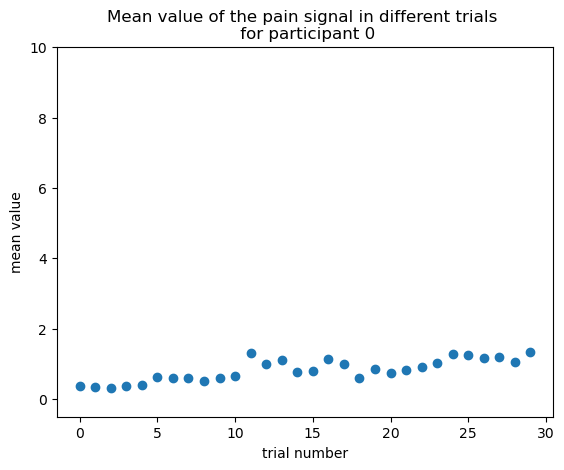

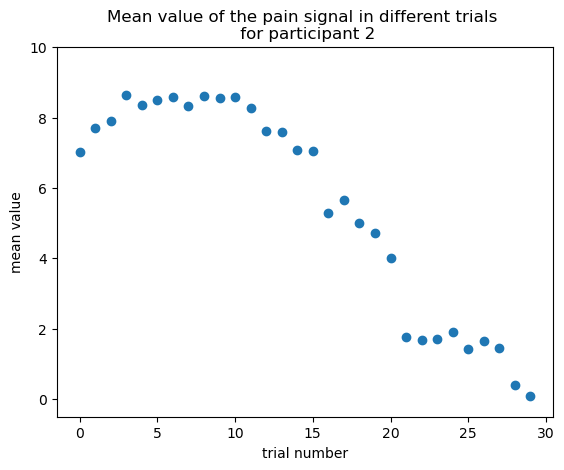

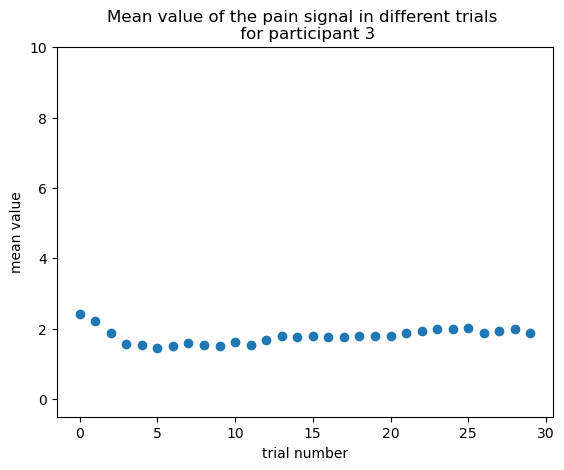

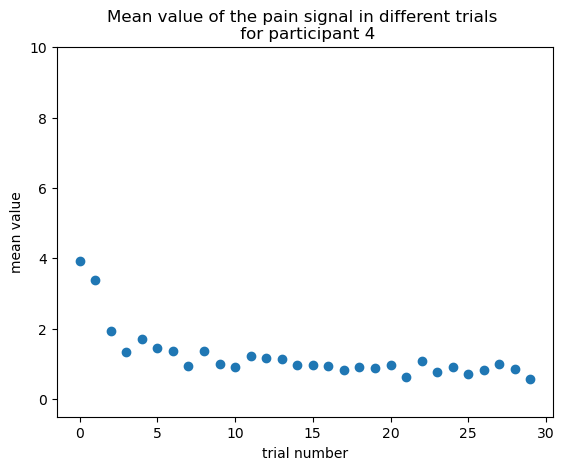

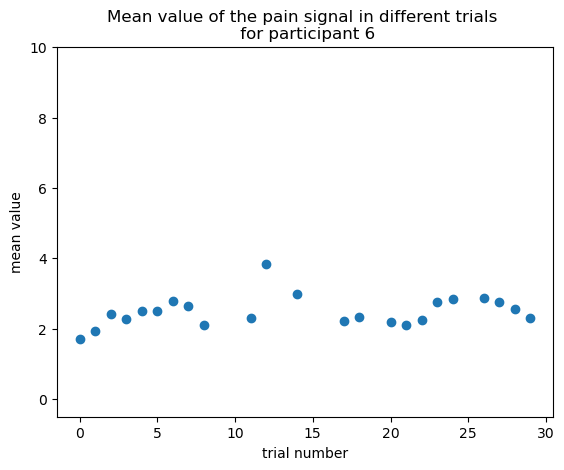

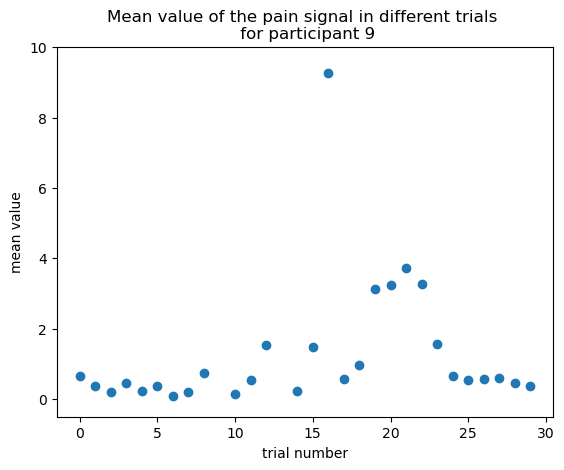

In [94]:
for i in retained_participants_list:
    plt.figure()
    plt.scatter(range(len(mean_list_all[i])), mean_list_all[i])
    plt.ylim(-0.5,10)
    plt.xlabel('trial number')
    plt.ylabel('mean value')
    plt.title(f'Mean value of the pain signal in different trials \n for participant {i}')

there's always a large spike somewhere during the task (a few of them have a spike at trial 20 onwards)

### Mean square

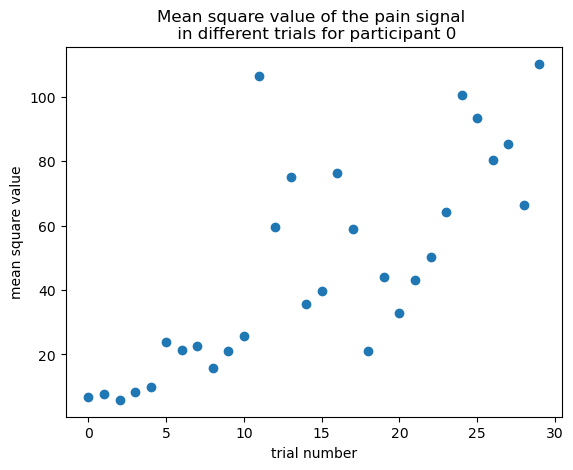

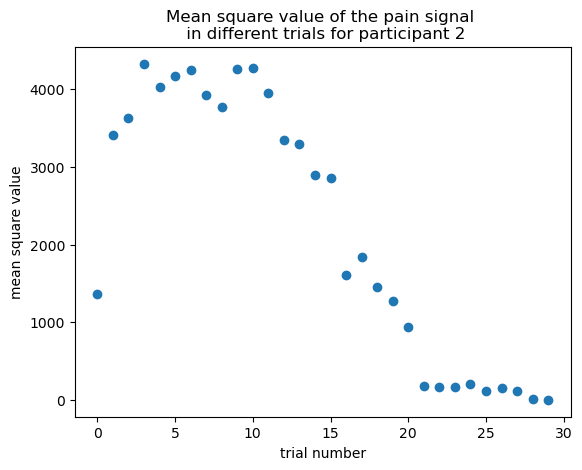

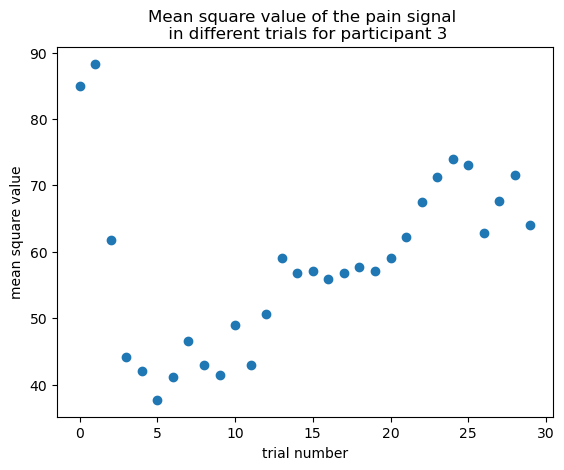

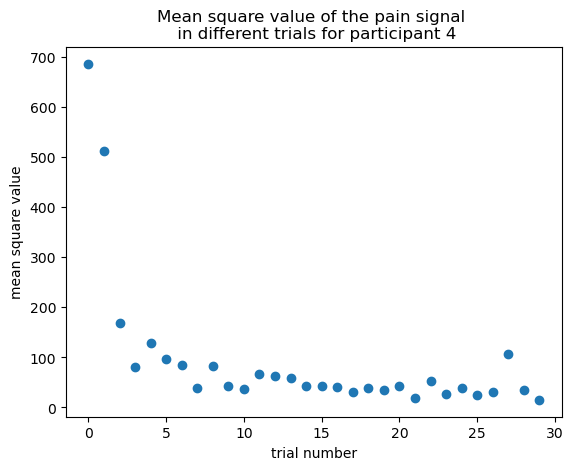

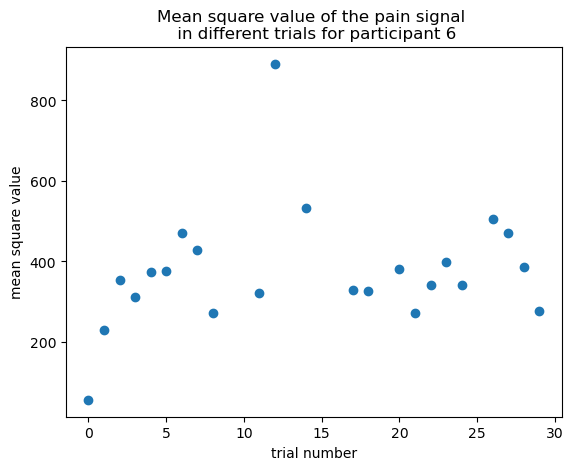

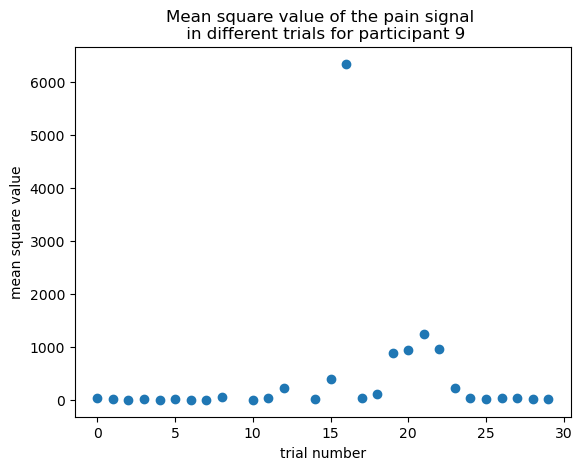

In [95]:
for i in retained_participants_list:
    plt.figure()
    plt.scatter(range(len(mean_square_list_all[i])), mean_square_list_all[i])
    plt.xlabel('trial number')
    plt.ylabel('mean square value')
    plt.title(f'Mean square value of the pain signal \n in different trials for participant {i}')

seem to be spikes of mean square value, some very obvious as well (a few of them have a spike at trial 20 onwards)

### Variance

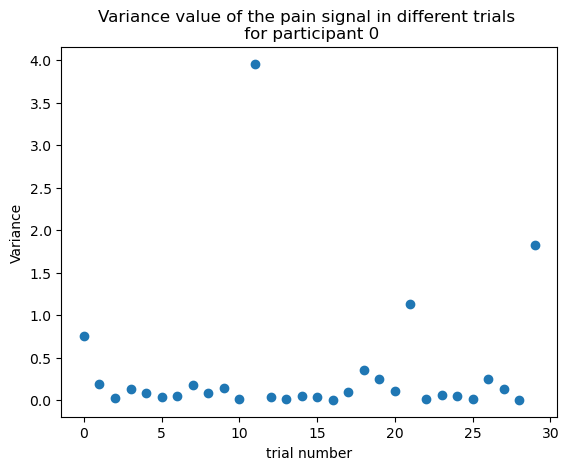

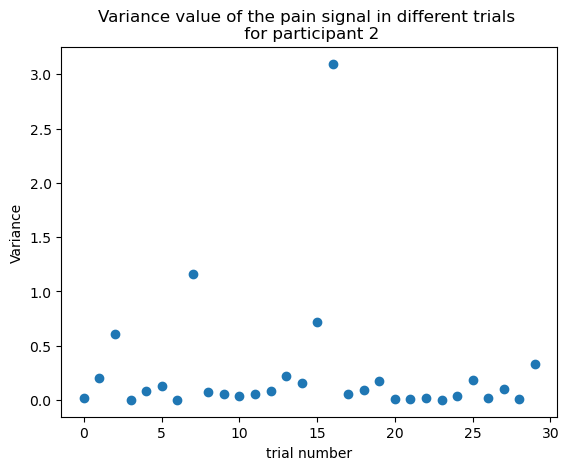

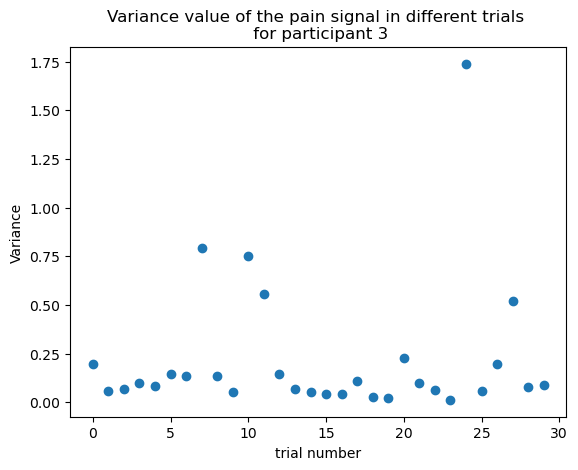

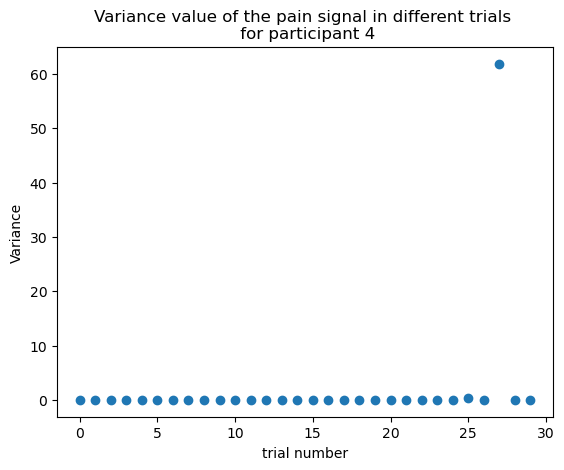

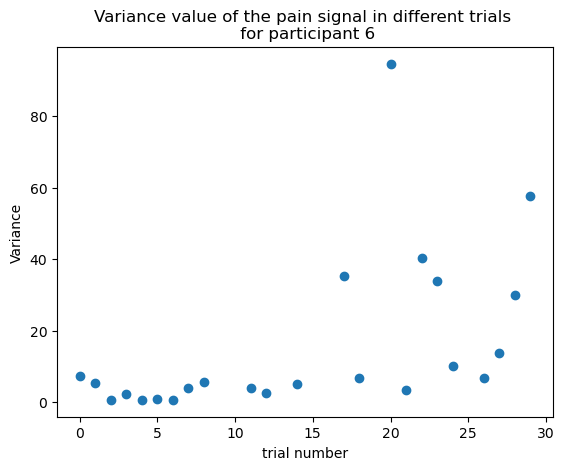

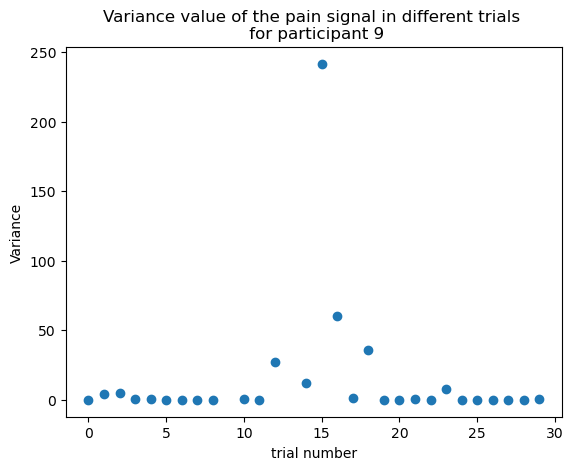

In [96]:
for i in retained_participants_list:
    plt.figure()
    plt.scatter(range(len(variance_list_all[i])), variance_list_all[i])
    plt.xlabel('trial number')
    plt.ylabel('Variance')
    plt.title(f'Variance value of the pain signal in different trials \n for participant {i}')

Interesting seeing spikes of different values of variances throughout the 30 trials, may be interesting looking at the pattern?

## Frequency
### FFT

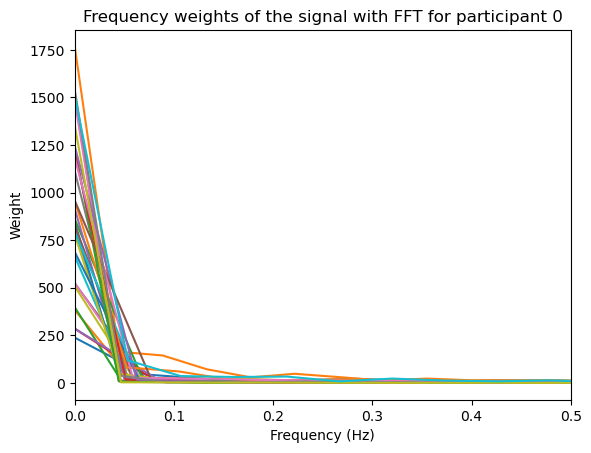

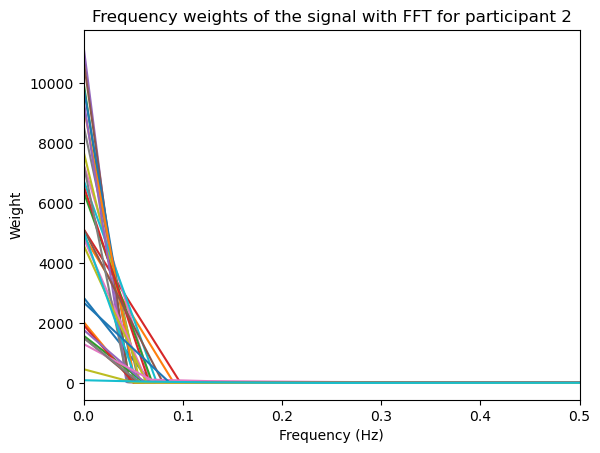

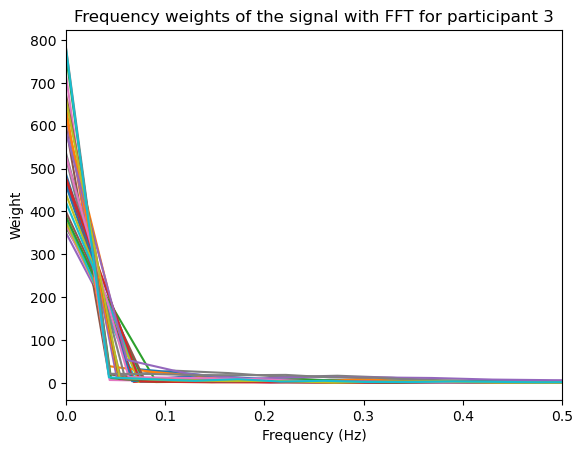

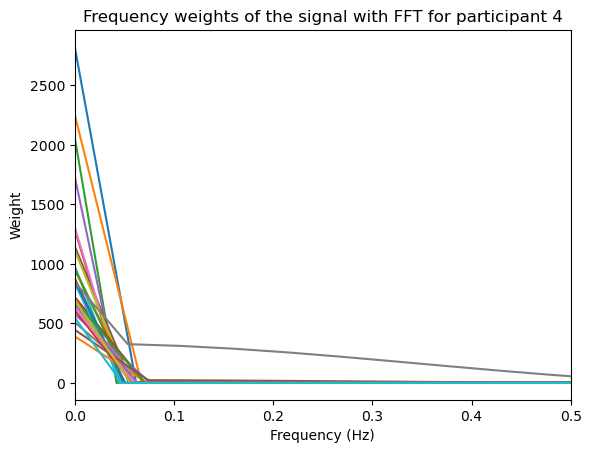

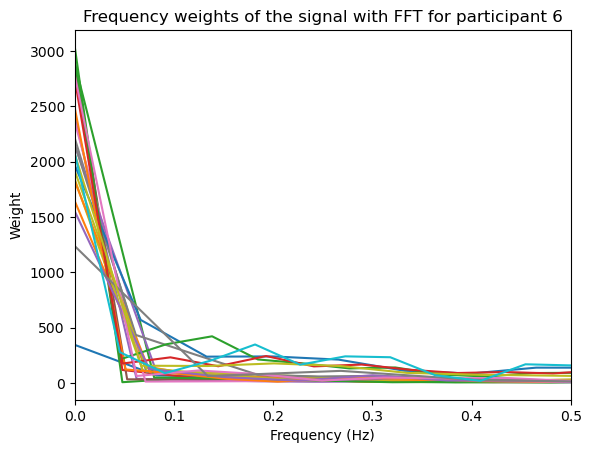

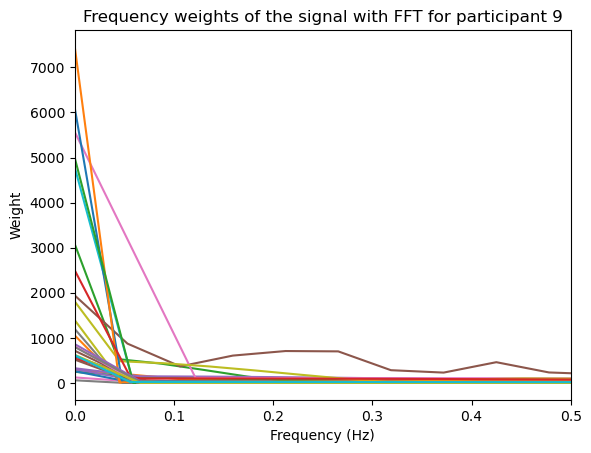

In [97]:
fft_weights_list_all = []
fft_freq_list_all = []
for j in retained_participants_list:
    plt.figure()
    fft_weights_list, fft_freq_list = fft_data(lowpass_list_all[j], time_windowed_list_all[j])
    fft_weights_list_all.append(fft_weights_list)
    fft_freq_list_all.append(fft_freq_list)
    for i in range(len(lowpass_list_all[j])):
        plt.plot(fft_freq_list[i], np.abs(fft_weights_list[i]))
    plt.xlim(0,0.5)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Weight')
    plt.title(f'Frequency weights of the signal with FFT for participant {j}')

### Power spectrum

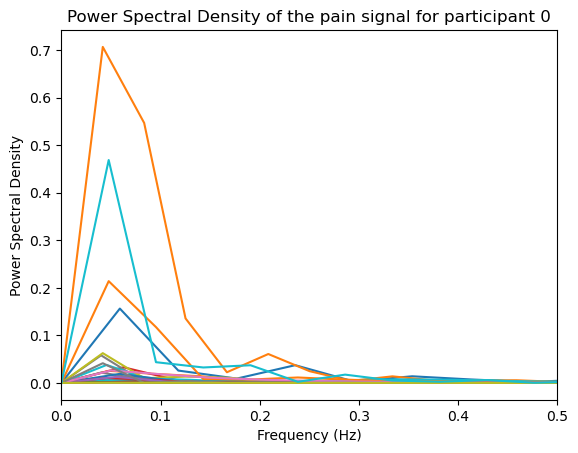

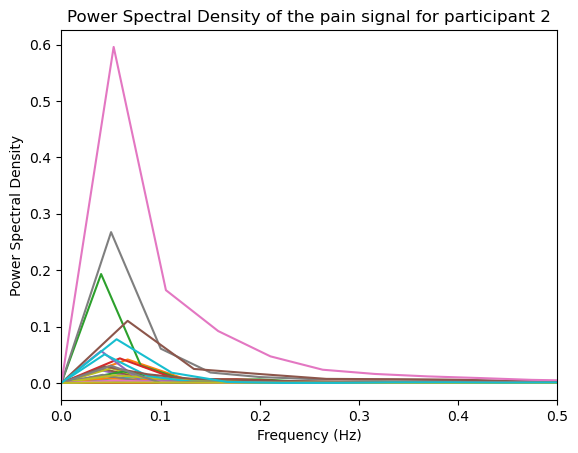

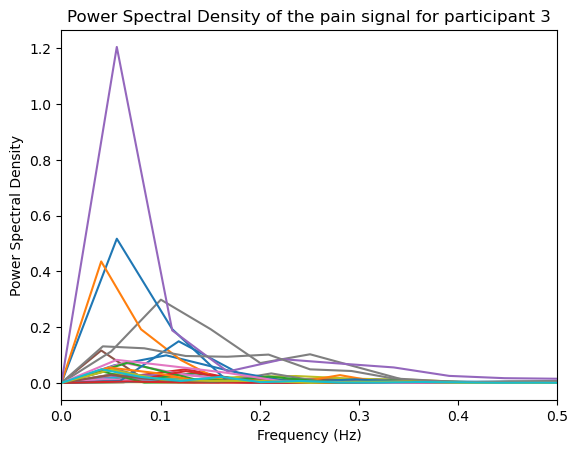

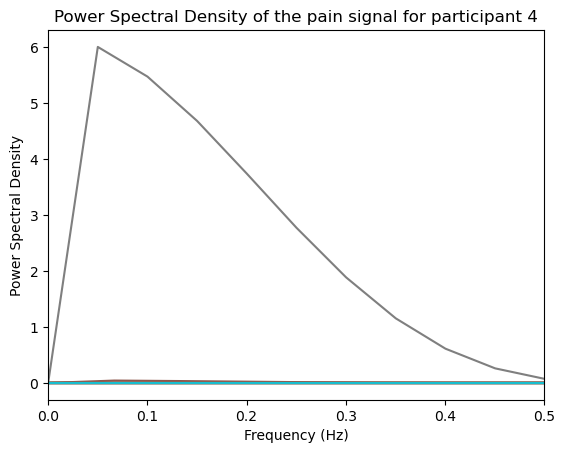

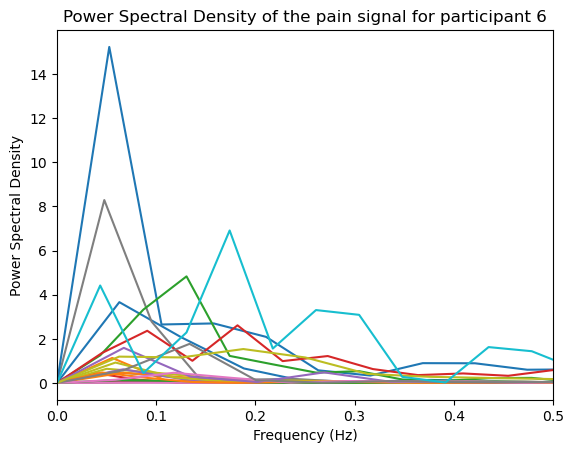

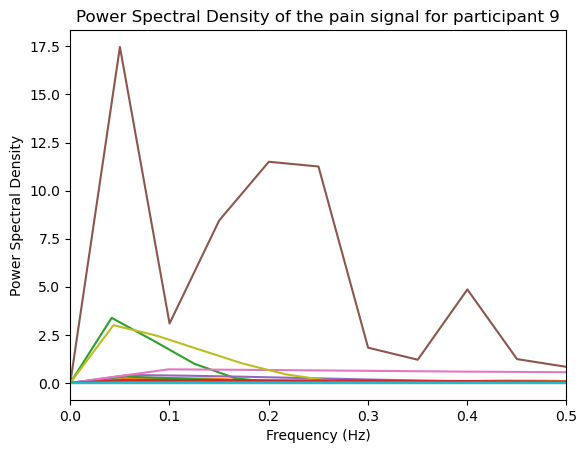

In [98]:
psd_freq_list_all = []
psd_list_all=[]
for j in retained_participants_list:
    plt.figure()
    psd_freq_list, psd_list = power_spectrum(lowpass_list_all[j], time_windowed_list_all[j])
    psd_freq_list_all.append(psd_freq_list)
    psd_list_all.append(psd_list)
    for i in range(len(lowpass_list_all[j])):
        plt.plot(psd_freq_list[i], np.abs(psd_list[i]))
    plt.xlim(0,0.5)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.title(f'Power Spectral Density of the pain signal for participant {j}')

## Permutation entropy

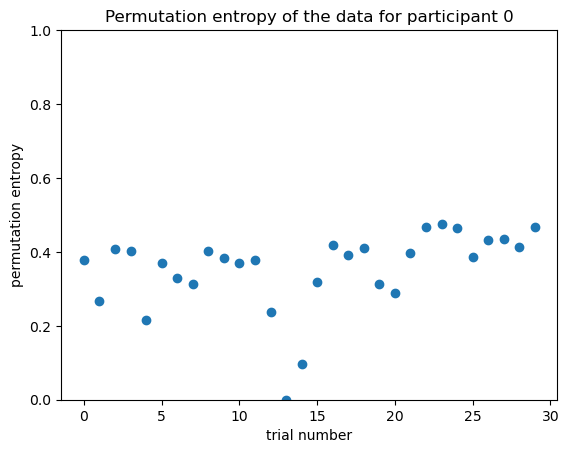

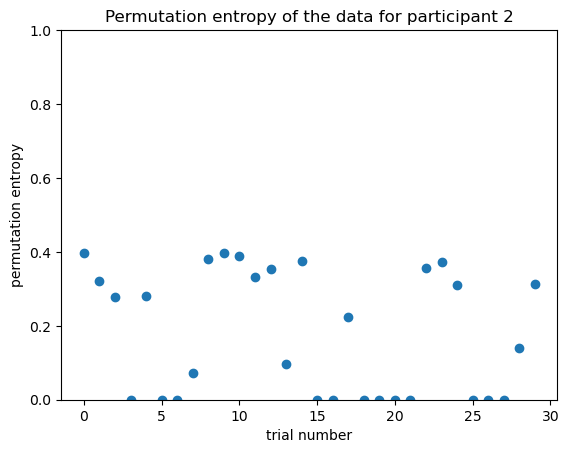

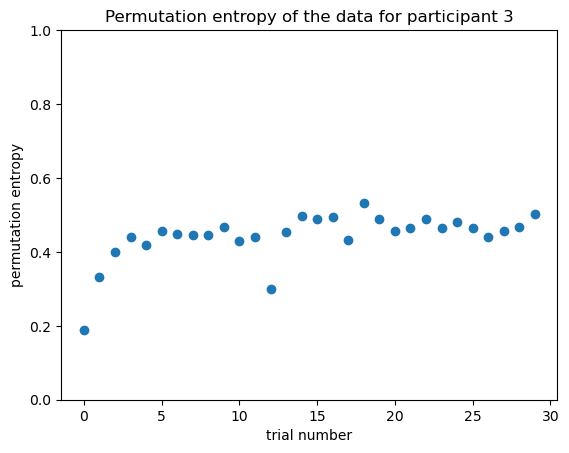

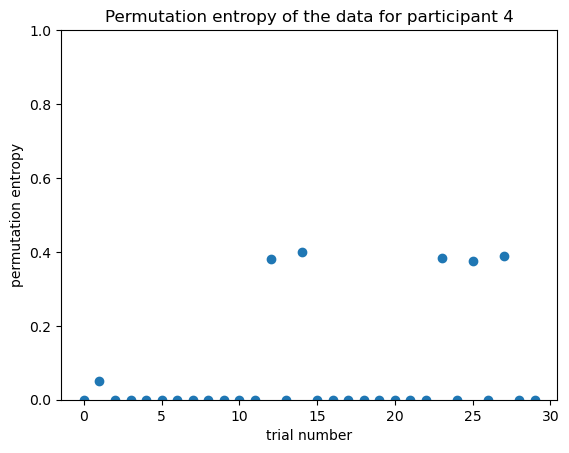

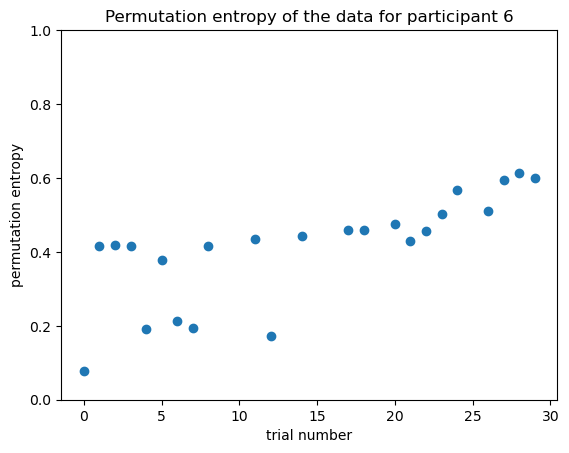

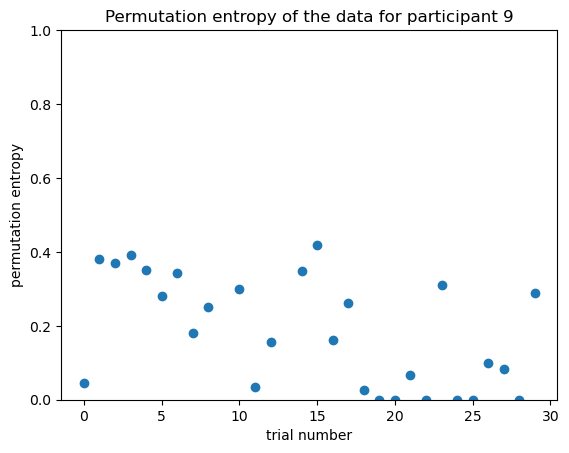

In [99]:
entropy_list_all = []
stat_complexity_list_all = []
for i in retained_participants_list:
    plt.figure()
    entropy_list, stat_complexity_list = permutation_entropy(lowpass_list_all[i])
    entropy_list_all.append(entropy_list)
    stat_complexity_list_all.append(stat_complexity_list)
    plt.scatter(range(len(entropy_list)), entropy_list)
    plt.title(f'Permutation entropy of the data for participant {i}')
    plt.xlabel('trial number')
    plt.ylabel('permutation entropy')
    plt.ylim(0,1)

It will be interesting to try to look at the fluctuations of entropy as there seem to be a pattern of going up and down?

## Autocorrelation

c:\Users\sharonho\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


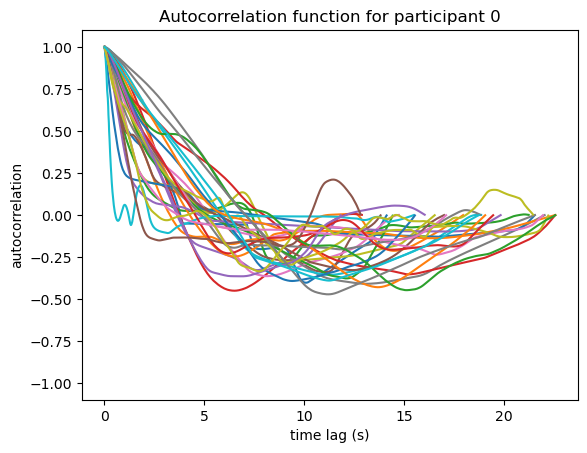

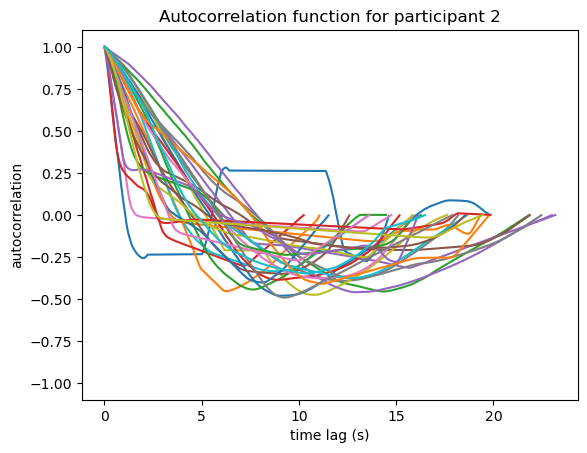

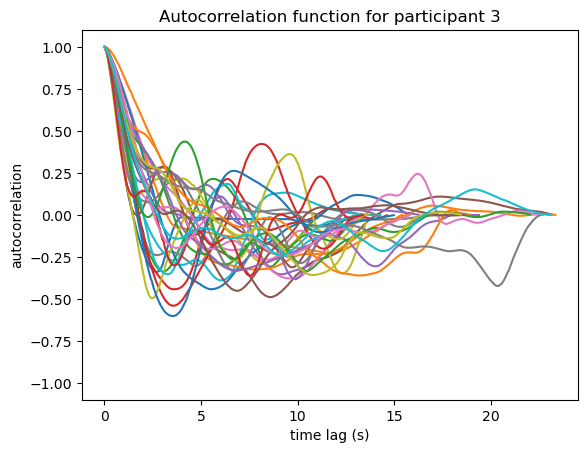

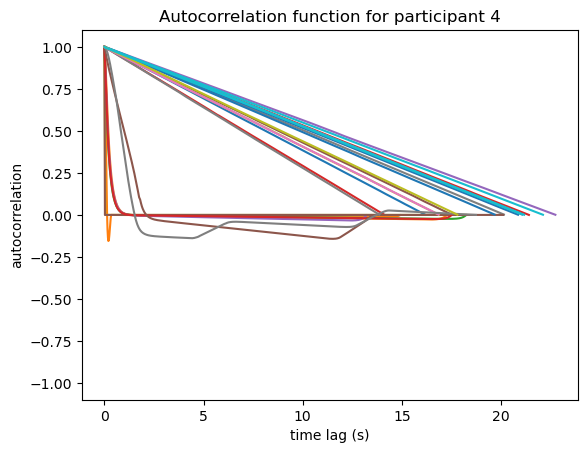

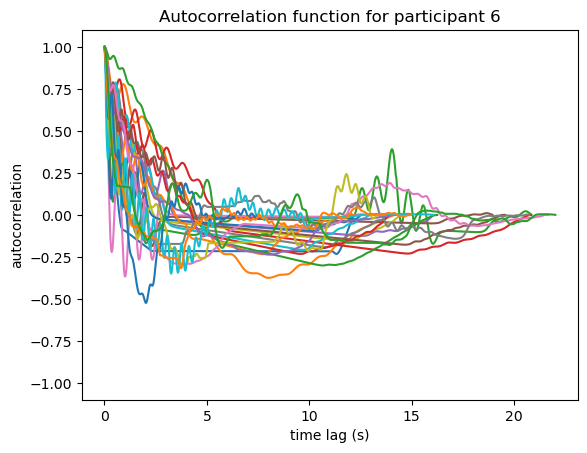

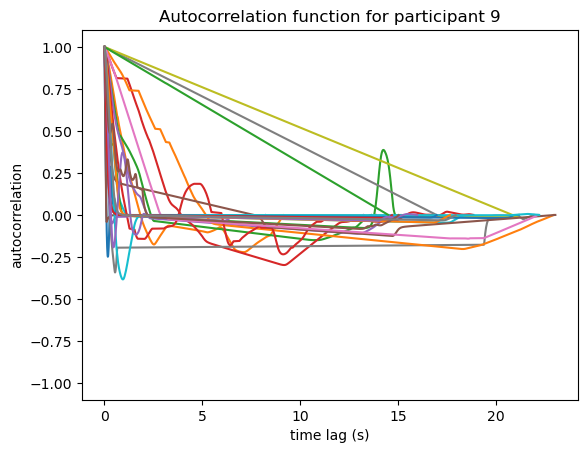

In [100]:
acorr_list_all = []
for j in retained_participants_list:
    plt.figure()
    acorr_list = autocorrelation(lowpass_list_all[j])
    acorr_list_all.append(acorr_list)

    for i in range(len(time_windowed_list_all[j])):
        if len(time_windowed_list_all[j][i]) > 1:
            time_lag = np.array(time_windowed_list_all[j][i]) - np.array(time_windowed_list_all[j][i][0])
            plt.plot(time_lag, acorr_list[i])
    plt.xlabel('time lag (s)')
    plt.ylabel('autocorrelation')
    plt.title(f'Autocorrelation function for participant {j}')
    plt.ylim(-1.1,1.1)

## Check stationarity

In [101]:
adfuller_list_all = []
stationary_list_all = []
for j in retained_participants_list:
    adfuller_list, labels, stationary_list = adfuller_test(lowpass_list_all[j])
    adfuller_list_all.append(adfuller_list)
    stationary_list_all.append(stationary_list)


c:\Users\sharonho\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\sharonho\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\sharonho\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\sharonho\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\sharonho\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nob

## Analysing the response of confidence and prediction
### From confidence and prediction data

In [102]:
mean_predict_all = []
mean_confidence_all = []
std_predict_all = []
std_confidence_all = []
for index in range(len(files)):
    if index in retained_participants_list:
        mean_predict = np.nanmean(predict_data_all[index].values)
        predict_std = np.nanstd(predict_data_all[index].values)
        mean_predict_all.append(mean_predict)
        std_predict_all.append(predict_std)
        confidence_predict = np.nanmean(confidence_data_all[index].values)
        confidence_std = np.nanstd(predict_data_all[index].values)
        mean_confidence_all.append(confidence_predict)
        std_confidence_all.append(confidence_std)
    else:
        mean_predict_all.append(np.nan)
        mean_confidence_all.append(np.nan)
        std_predict_all.append(np.nan)
        std_confidence_all.append(np.nan)



### From continuous pain rating data

In [103]:
mean_list_all_total = []
variance_list_all_total = []
for index in range(len(files)):
    if index in retained_participants_list:
        mean_list_all_total.append(np.nanmean(mean_list_all[index]))
        variance_list_all_total.append(np.nanmean(variance_list_all[index]))
    else:
        mean_list_all_total.append(np.nan)
        variance_list_all_total.append(np.nan)
std_list_all_total = np.sqrt(np.array(variance_list_all_total))

### Plotting it all together

c:\Users\sharonho\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\sharonho\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


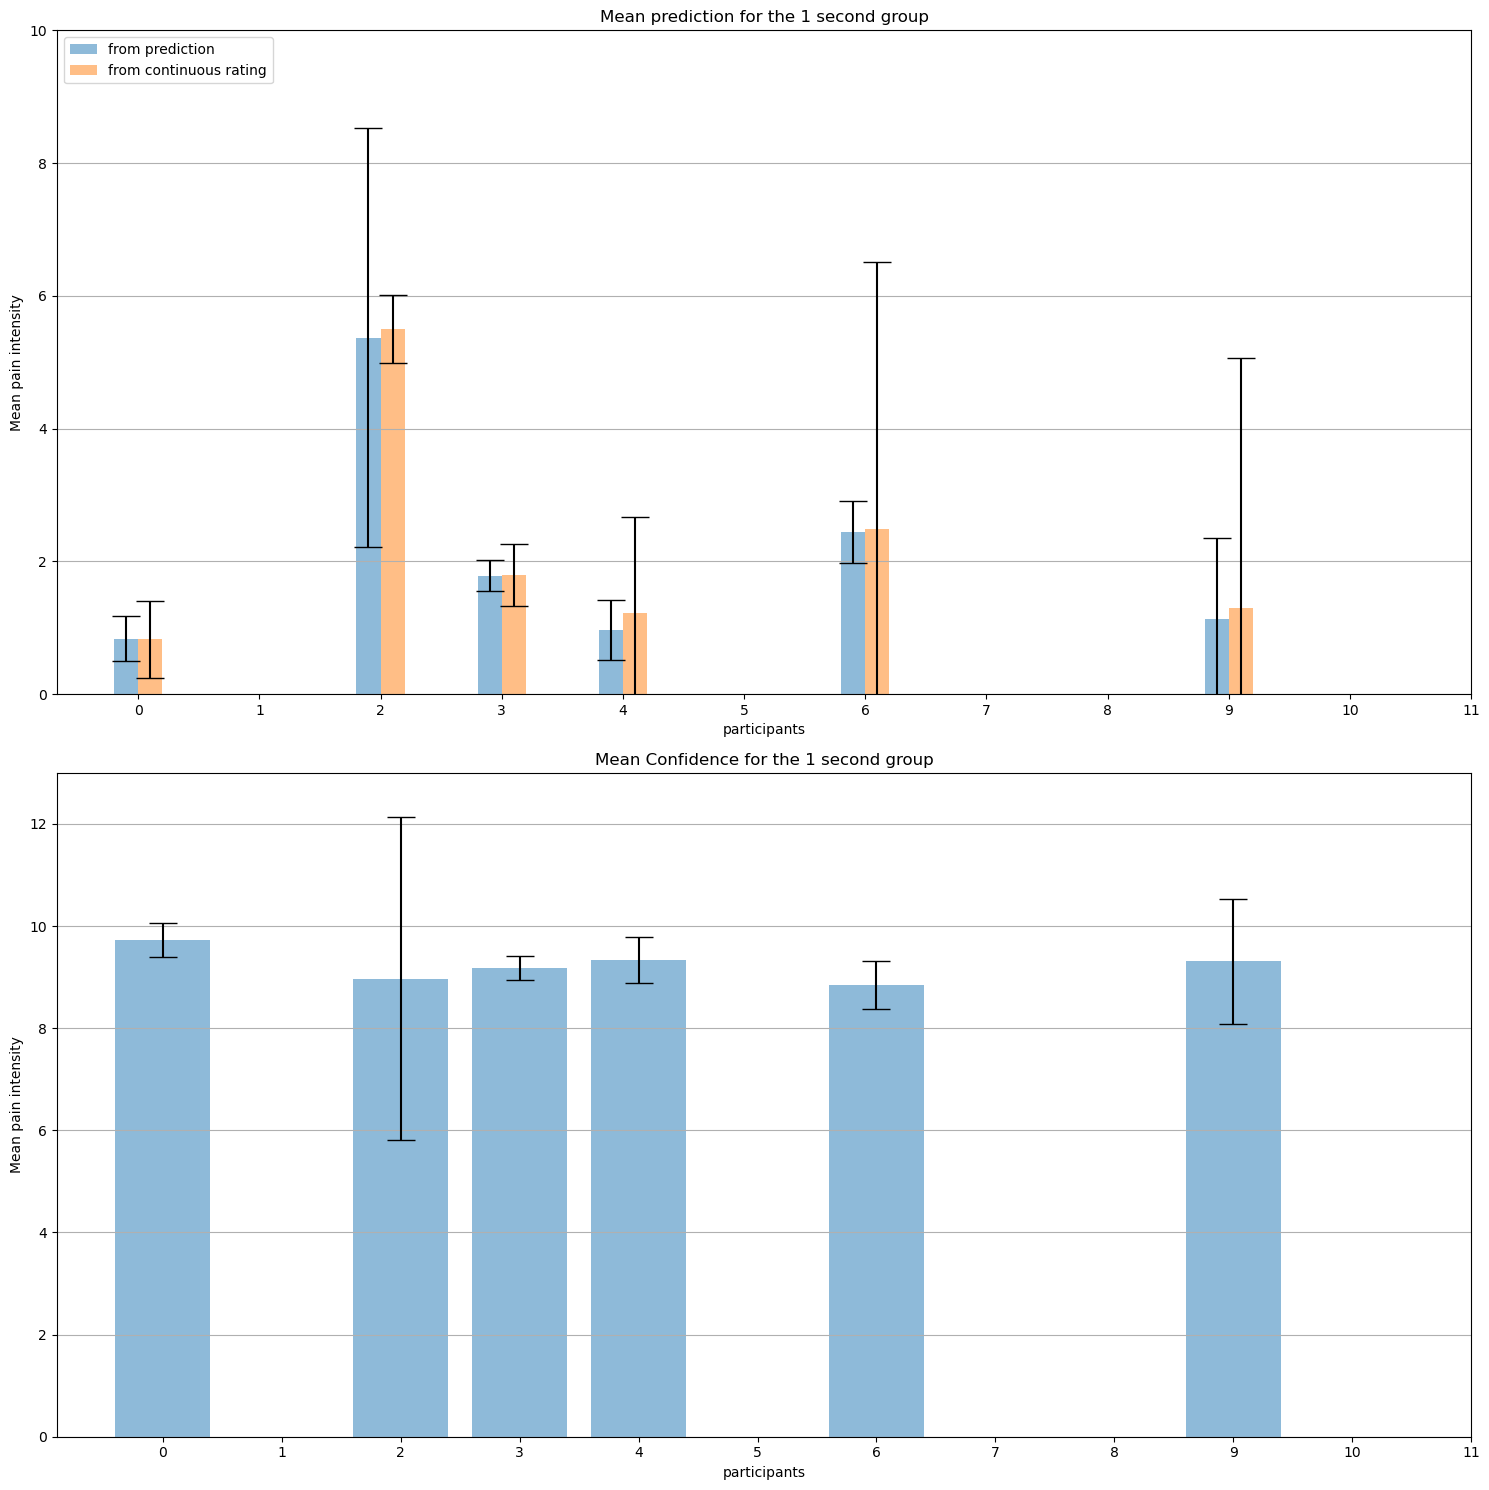

In [104]:
ticks = np.arange(len(files))


fig, ax = plt.subplots(2, figsize=(15, 15))
rects1 = ax[0].bar(ticks - 0.1, mean_predict_all, width = 0.2,
       yerr=std_predict_all,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)

rects2 = ax[0].bar(ticks + 0.1, mean_list_all_total, width = 0.2,
       yerr=std_list_all_total,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)

ax[0].set_xticks(ticks)
ax[0].set_title('Mean prediction for the 1 second group')
ax[0].set_xlabel('participants')
ax[0].set_ylabel('Mean pain intensity')
ax[0].yaxis.grid(True)
ax[0].set_ylim(0,10)
ax[0].legend( (rects1[0], rects2[0]), ('from prediction', 'from continuous rating') )



ax[1].bar(ticks, mean_confidence_all, 
       yerr=std_confidence_all,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)

ax[1].set_xticks(ticks)
ax[1].set_title('Mean Confidence for the 1 second group')
ax[1].set_xlabel('participants')
ax[1].set_ylabel('Mean pain intensity')
ax[1].yaxis.grid(True)
ax[1].set_ylim(0,13)


plt.tight_layout()
plt.savefig('second.png')

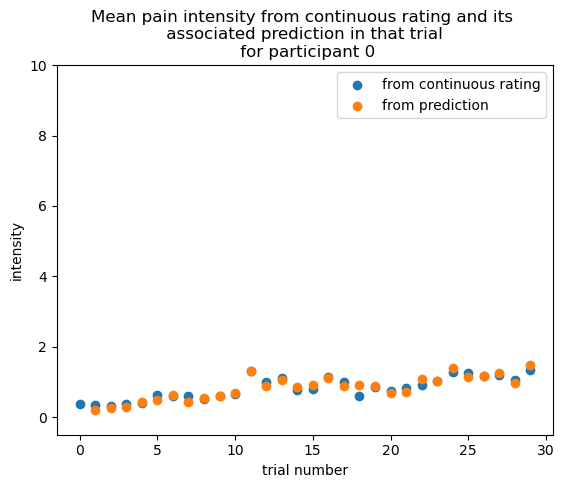

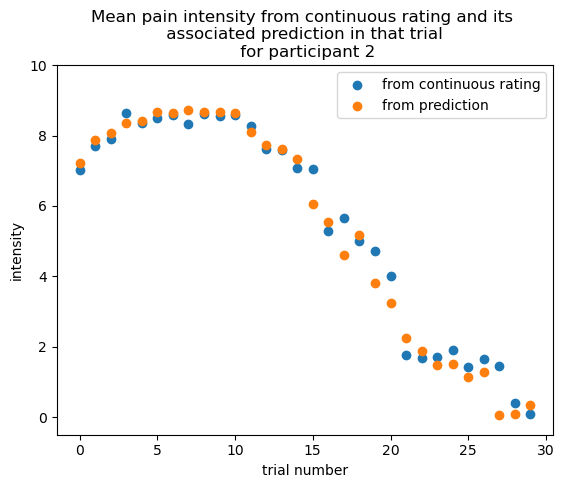

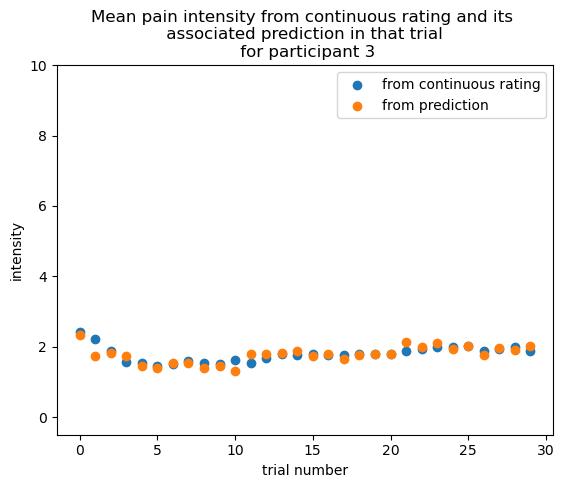

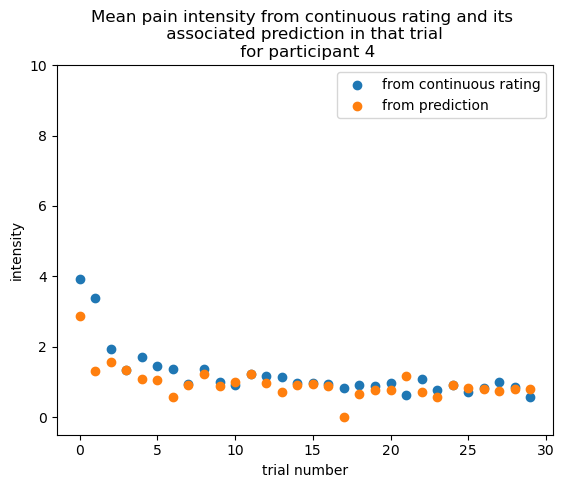

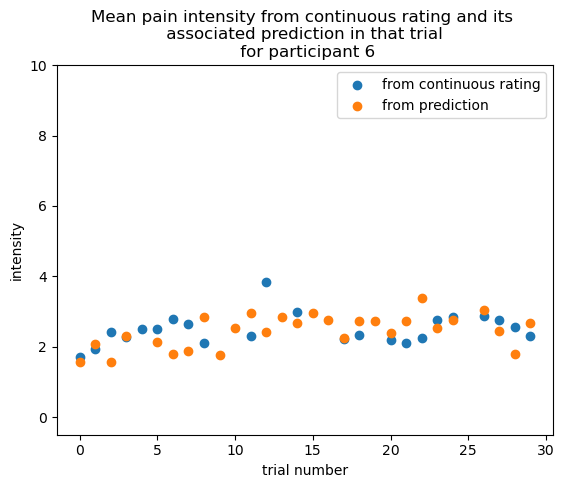

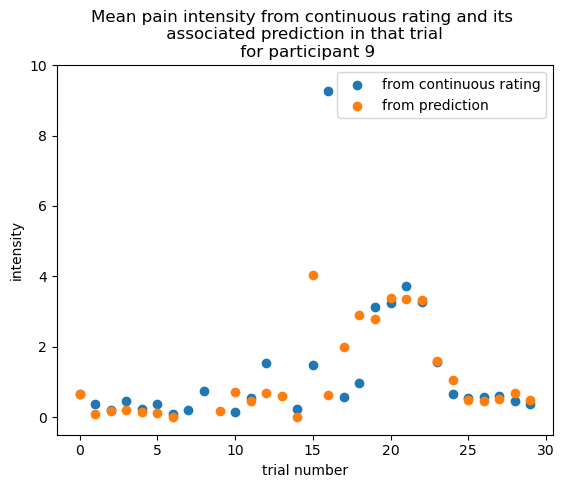

In [105]:
for i in retained_participants_list:
    plt.figure()
    plt.scatter(range(len(mean_list_all[i])), mean_list_all[i], label = 'from continuous rating')
    plt.scatter(range(len(mean_list_all[i])), predict_data_all[i], label = 'from prediction')
    plt.ylim(-0.5,10)
    plt.xlabel('trial number')
    plt.ylabel('intensity')
    plt.legend()
    plt.title(f'Mean pain intensity from continuous rating and its \n associated prediction in that trial \n for participant {i}')
    plt.savefig(f'continuous_vs_prediction_{i}_seconds')